In [1]:
# Importar TensorFlow y Keras 
# Importacion de librerias
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras import layers, Sequential, optimizers
from tensorflow.keras import layers, models, Sequential, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array

# Librerías para preprocesamiento y métricas
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Configuración de TensorFlow
print("Versión de TensorFlow:", tf.__version__)
print("¿TensorFlow está usando GPU?")
print(tf.config.list_physical_devices('GPU'))

Versión de TensorFlow: 2.10.0
¿TensorFlow está usando GPU?
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Configuración de rutas
data_paths = {
    "Mel-512": "..\\Analisis_Espectros\\DataSetImages_FULL\\DataSetImages\\Spectrograms\\Mel-512",
    "Mel-1024": "..\\Analisis_Espectros\\DataSetImages_FULL\\DataSetImages/Spectrograms\\Mel-1024",
    "Bump": "..\\Analisis_Espectros\\DataSetImages_FULL\\DataSetImages\\Scalograms\\Bump",
    "Morlet": "..\\Analisis_Espectros\\DataSetImages_FULL\\DataSetImages\\Scalograms\\Morlet"
}

In [4]:
def load_and_preprocess_data(data_path, batch_size=50, img_size=(224, 224)):
    # Cargar datasets de entrenamiento y validación
    raw_train_ds = tf.keras.utils.image_dataset_from_directory(
        data_path,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=img_size,
        batch_size=batch_size
    )
    raw_val_ds = tf.keras.utils.image_dataset_from_directory(
        data_path,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=img_size,
        batch_size=batch_size
    )

    # Extraer nombres de las clases
    class_names = raw_train_ds.class_names

    # Normalizar los datos
    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
    train_ds = raw_train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = raw_val_ds.map(lambda x, y: (normalization_layer(x), y))

    # Prefetch para optimizar
    train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_ds, val_ds, class_names

In [5]:
# Función para crear el modelo
def create_model(num_classes):
    base_model = ResNet101V2(
        weights="imagenet",
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model

In [6]:
# Función para entrenar el modelo (Transfer Learning)
def train_model(model, train_ds, val_ds, epochs=25):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
    return history

In [7]:
# Función para realizar Fine-Tuning
def fine_tune_model(model, train_ds, val_ds, base_learning_rate=0.0001, fine_tune_at=90):
    model.layers[0].trainable = True
    for layer in model.layers[0].layers[:fine_tune_at]:
        layer.trainable = False
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate / 10),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    history = model.fit(train_ds, validation_data=val_ds, epochs=100)
    return history

In [8]:
def generate_classification_report(model, val_ds, class_names, title=""):
    y_true = []
    y_pred = []

    # Obtener predicciones
    for images, labels in val_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    # Reporte de clasificación
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    print(f"\nReporte de Clasificación para {title}:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{title} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return report

In [9]:
# Función para graficar métricas de entrenamiento
def plot_training_history(history, title=""):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{title} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{title} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Procesando representación: Mel-512
Found 5363 files belonging to 7 classes.
Using 4291 files for training.
Found 5363 files belonging to 7 classes.
Using 1072 files for validation.
Epoch 1/25
86/86 [==============================] - 28s 208ms/step - loss: 1.2847 - accuracy: 0.5267 - val_loss: 0.8990 - val_accuracy: 0.7034
Epoch 2/25
86/86 [==============================] - 17s 188ms/step - loss: 0.8631 - accuracy: 0.6935 - val_loss: 0.7480 - val_accuracy: 0.7481
Epoch 3/25
86/86 [==============================] - 16s 186ms/step - loss: 0.7325 - accuracy: 0.7388 - val_loss: 0.6760 - val_accuracy: 0.7752
Epoch 4/25
86/86 [==============================] - 17s 188ms/step - loss: 0.6616 - accuracy: 0.7737 - val_loss: 0.6431 - val_accuracy: 0.7892
Epoch 5/25
86/86 [==============================] - 17s 190ms/step - loss: 0.5968 - accuracy: 0.7905 - val_loss: 0.5685 - val_accuracy: 0.8153
Epoch 6/25
86/86 [==============================] - 18s 201ms/step - loss: 0.5355 - accuracy: 0.8173 - v

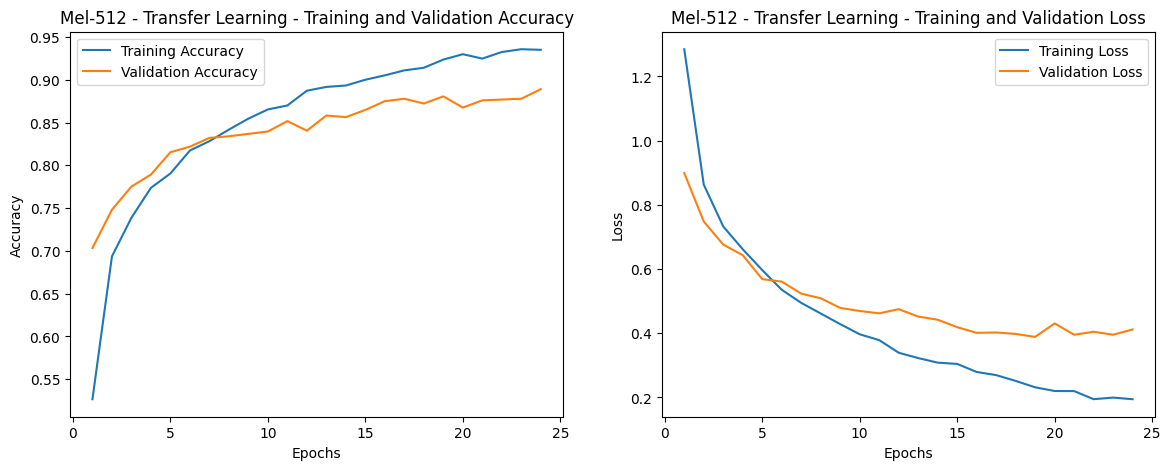

1/1 [==============================] - 0s 106ms/step

Reporte de Clasificación para Mel-512 - Transfer Learning:

                  precision    recall  f1-score   support

 air_conditioner       0.85      0.94      0.90       143
children_playing       0.83      0.83      0.83       133
        drilling       0.85      0.90      0.88       168
   engine_idling       0.94      0.87      0.90       150
      jackhammer       0.91      0.91      0.91       156
           siren       0.91      0.89      0.90       161
    street_music       0.87      0.81      0.84       161

        accuracy                           0.88      1072
       macro avg       0.88      0.88      0.88      1072
    weighted avg       0.88      0.88      0.88      1072



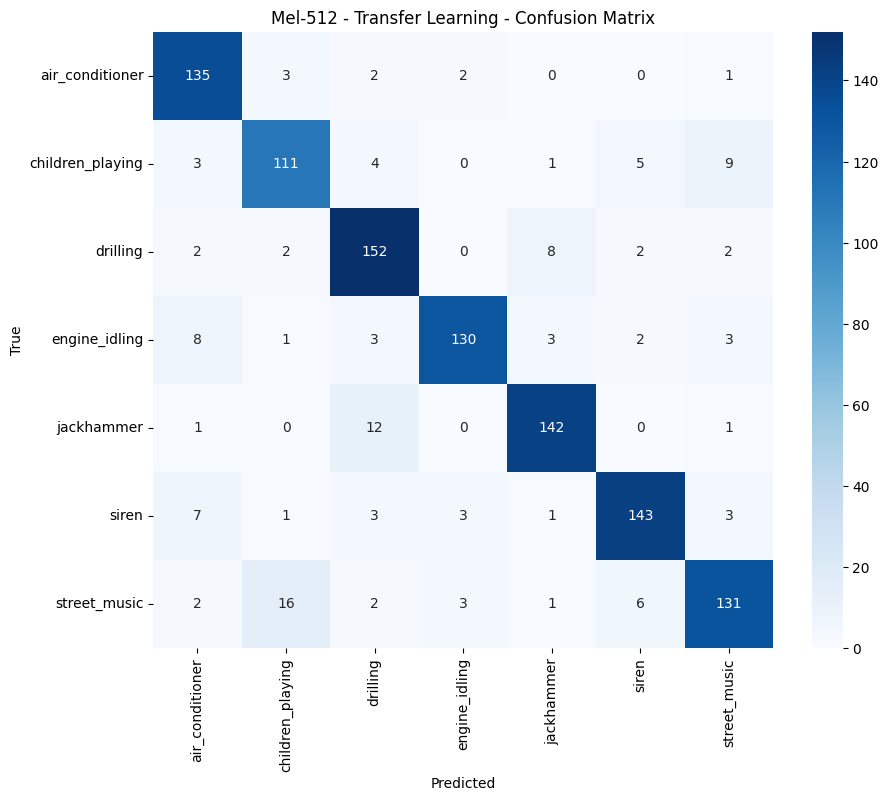

Epoch 1/50
86/86 [==============================] - 74s 517ms/step - loss: 11.6993 - accuracy: 0.2021 - val_loss: 3.2298 - val_accuracy: 0.4543
Epoch 2/50
86/86 [==============================] - 39s 444ms/step - loss: 9.6626 - accuracy: 0.2400 - val_loss: 5.2071 - val_accuracy: 0.3386
Epoch 3/50
86/86 [==============================] - 38s 439ms/step - loss: 8.1068 - accuracy: 0.2694 - val_loss: 5.2010 - val_accuracy: 0.3433
Epoch 4/50
86/86 [==============================] - 39s 441ms/step - loss: 6.4767 - accuracy: 0.3242 - val_loss: 4.6281 - val_accuracy: 0.3750
Epoch 5/50
86/86 [==============================] - 38s 438ms/step - loss: 5.1816 - accuracy: 0.3752 - val_loss: 3.9678 - val_accuracy: 0.4244
Epoch 6/50
86/86 [==============================] - 38s 440ms/step - loss: 4.0007 - accuracy: 0.4237 - val_loss: 3.4421 - val_accuracy: 0.4571
Epoch 7/50
86/86 [==============================] - 38s 438ms/step - loss: 3.1306 - accuracy: 0.4826 - val_loss: 2.9915 - val_accuracy: 0.487

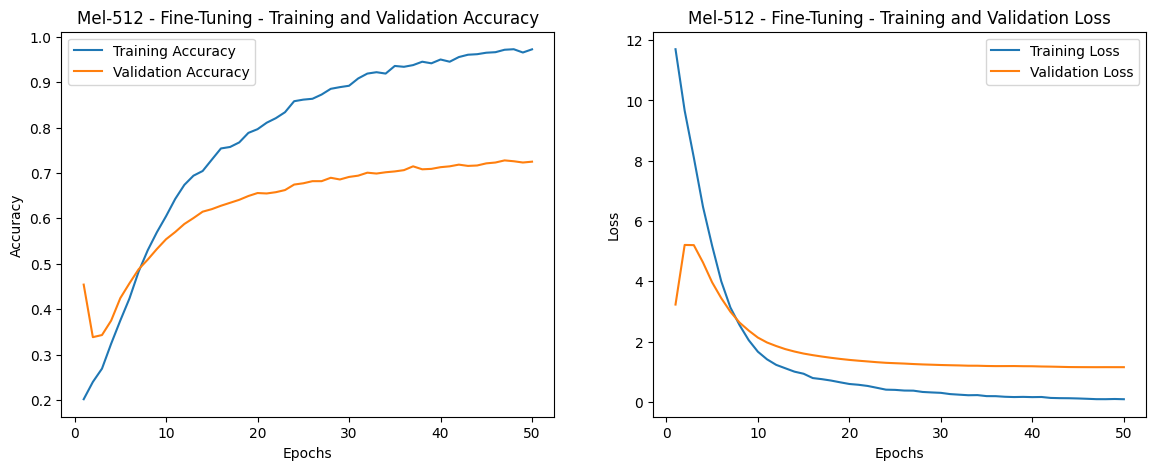

1/1 [==============================] - 0s 113ms/step

Reporte de Clasificación para Mel-512 - Fine-Tuning:

                  precision    recall  f1-score   support

 air_conditioner       0.69      0.76      0.72       143
children_playing       0.65      0.69      0.67       133
        drilling       0.72      0.73      0.72       168
   engine_idling       0.74      0.72      0.73       150
      jackhammer       0.74      0.78      0.76       156
           siren       0.86      0.78      0.82       161
    street_music       0.67      0.63      0.65       161

        accuracy                           0.73      1072
       macro avg       0.73      0.73      0.72      1072
    weighted avg       0.73      0.73      0.73      1072



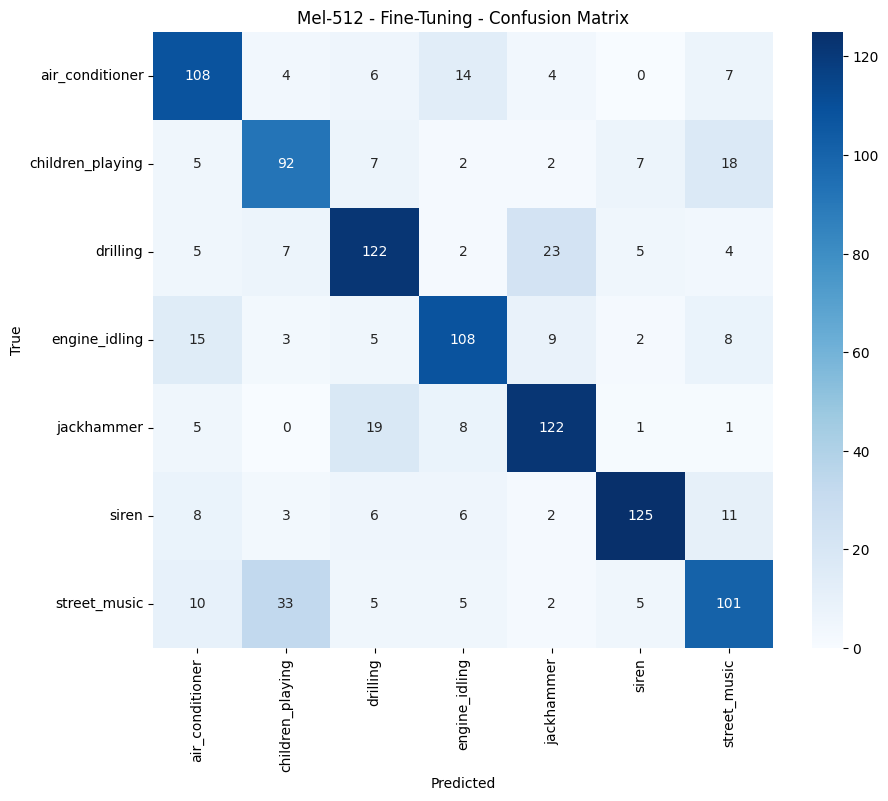

Procesando representación: Mel-1024
Found 5362 files belonging to 7 classes.
Using 4290 files for training.
Found 5362 files belonging to 7 classes.
Using 1072 files for validation.
Epoch 1/25
86/86 [==============================] - 43s 296ms/step - loss: 1.2423 - accuracy: 0.5503 - val_loss: 0.7984 - val_accuracy: 0.7519
Epoch 2/25
86/86 [==============================] - 20s 226ms/step - loss: 0.7975 - accuracy: 0.7294 - val_loss: 0.6821 - val_accuracy: 0.7649
Epoch 3/25
86/86 [==============================] - 20s 226ms/step - loss: 0.6861 - accuracy: 0.7678 - val_loss: 0.6071 - val_accuracy: 0.7789
Epoch 4/25
86/86 [==============================] - 21s 233ms/step - loss: 0.5936 - accuracy: 0.7907 - val_loss: 0.5349 - val_accuracy: 0.8218
Epoch 5/25
86/86 [==============================] - 22s 254ms/step - loss: 0.5226 - accuracy: 0.8266 - val_loss: 0.4845 - val_accuracy: 0.8358
Epoch 6/25
86/86 [==============================] - 26s 290ms/step - loss: 0.4776 - accuracy: 0.8394 - 

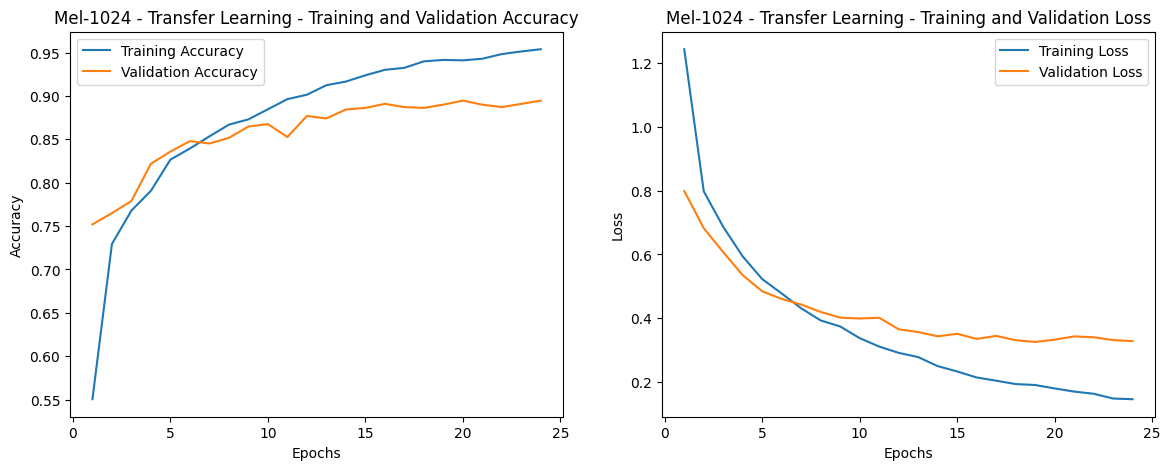

1/1 [==============================] - 0s 116ms/step

Reporte de Clasificación para Mel-1024 - Transfer Learning:

                  precision    recall  f1-score   support

 air_conditioner       0.87      0.91      0.89       143
children_playing       0.87      0.86      0.86       133
        drilling       0.85      0.91      0.88       168
   engine_idling       0.92      0.89      0.90       149
      jackhammer       0.93      0.92      0.92       157
           siren       0.92      0.92      0.92       161
    street_music       0.89      0.83      0.86       161

        accuracy                           0.89      1072
       macro avg       0.89      0.89      0.89      1072
    weighted avg       0.89      0.89      0.89      1072



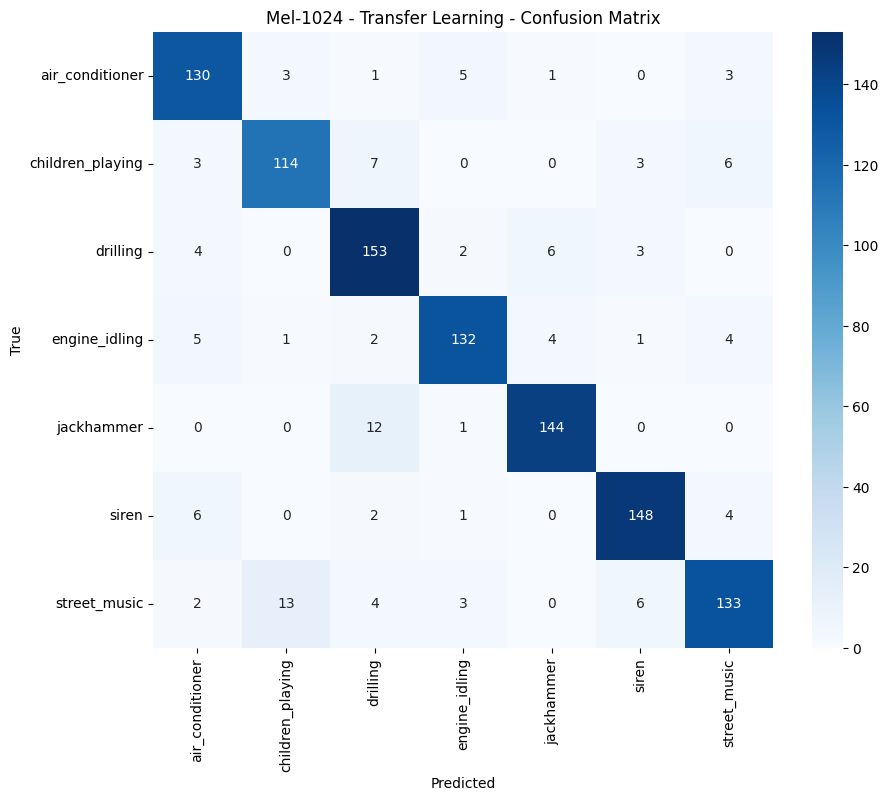

Epoch 1/50
86/86 [==============================] - 69s 495ms/step - loss: 12.0072 - accuracy: 0.2315 - val_loss: 3.4984 - val_accuracy: 0.5177
Epoch 2/50
86/86 [==============================] - 38s 431ms/step - loss: 9.6215 - accuracy: 0.2881 - val_loss: 5.6977 - val_accuracy: 0.4123
Epoch 3/50
86/86 [==============================] - 38s 432ms/step - loss: 7.8437 - accuracy: 0.3275 - val_loss: 5.6622 - val_accuracy: 0.4030
Epoch 4/50
86/86 [==============================] - 38s 431ms/step - loss: 6.2247 - accuracy: 0.3718 - val_loss: 4.9235 - val_accuracy: 0.4291
Epoch 5/50
86/86 [==============================] - 38s 431ms/step - loss: 4.7247 - accuracy: 0.4347 - val_loss: 4.2012 - val_accuracy: 0.4534
Epoch 6/50
86/86 [==============================] - 39s 451ms/step - loss: 3.5776 - accuracy: 0.4998 - val_loss: 3.5702 - val_accuracy: 0.4851
Epoch 7/50
86/86 [==============================] - 38s 433ms/step - loss: 2.7020 - accuracy: 0.5459 - val_loss: 3.0462 - val_accuracy: 0.514

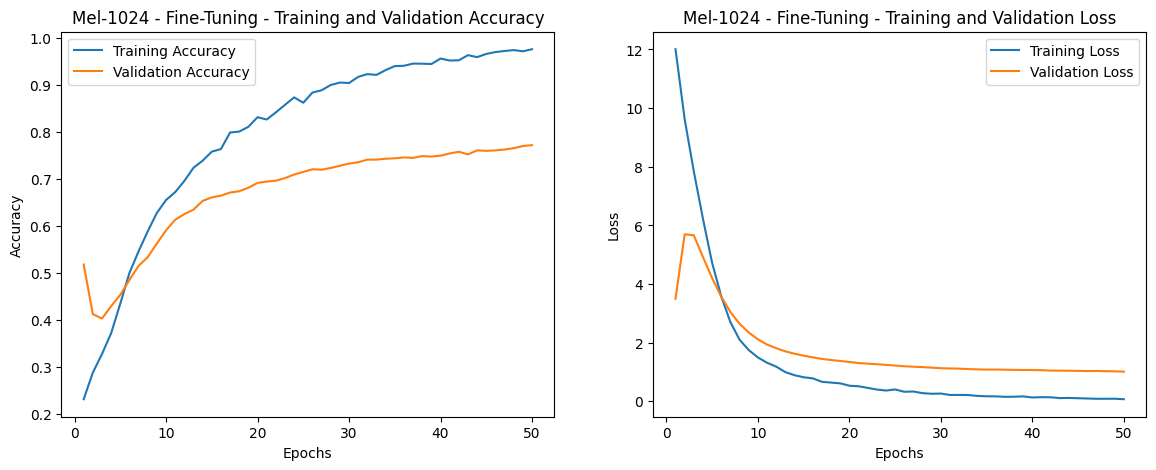

1/1 [==============================] - 0s 113ms/step

Reporte de Clasificación para Mel-1024 - Fine-Tuning:

                  precision    recall  f1-score   support

 air_conditioner       0.81      0.76      0.78       143
children_playing       0.72      0.69      0.71       133
        drilling       0.75      0.80      0.77       168
   engine_idling       0.77      0.78      0.78       149
      jackhammer       0.84      0.84      0.84       157
           siren       0.81      0.79      0.80       161
    street_music       0.70      0.73      0.71       161

        accuracy                           0.77      1072
       macro avg       0.77      0.77      0.77      1072
    weighted avg       0.77      0.77      0.77      1072



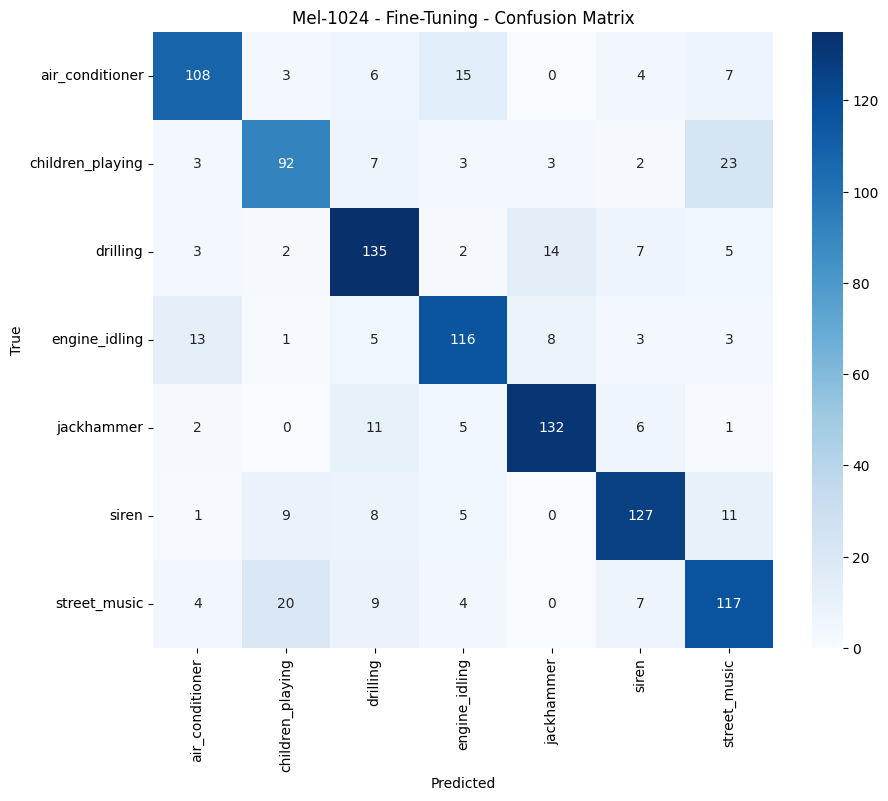

Procesando representación: Bump
Found 5362 files belonging to 7 classes.
Using 4290 files for training.
Found 5362 files belonging to 7 classes.
Using 1072 files for validation.
Epoch 1/25
86/86 [==============================] - 45s 321ms/step - loss: 1.2847 - accuracy: 0.5124 - val_loss: 0.8884 - val_accuracy: 0.6912
Epoch 2/25
86/86 [==============================] - 22s 247ms/step - loss: 0.9249 - accuracy: 0.6650 - val_loss: 0.8024 - val_accuracy: 0.7229
Epoch 3/25
86/86 [==============================] - 22s 253ms/step - loss: 0.8027 - accuracy: 0.7044 - val_loss: 0.7238 - val_accuracy: 0.7509
Epoch 4/25
86/86 [==============================] - 22s 244ms/step - loss: 0.7227 - accuracy: 0.7343 - val_loss: 0.6569 - val_accuracy: 0.7743
Epoch 5/25
86/86 [==============================] - 22s 250ms/step - loss: 0.6541 - accuracy: 0.7660 - val_loss: 0.6155 - val_accuracy: 0.7845
Epoch 6/25
86/86 [==============================] - 22s 241ms/step - loss: 0.6084 - accuracy: 0.7830 - val_

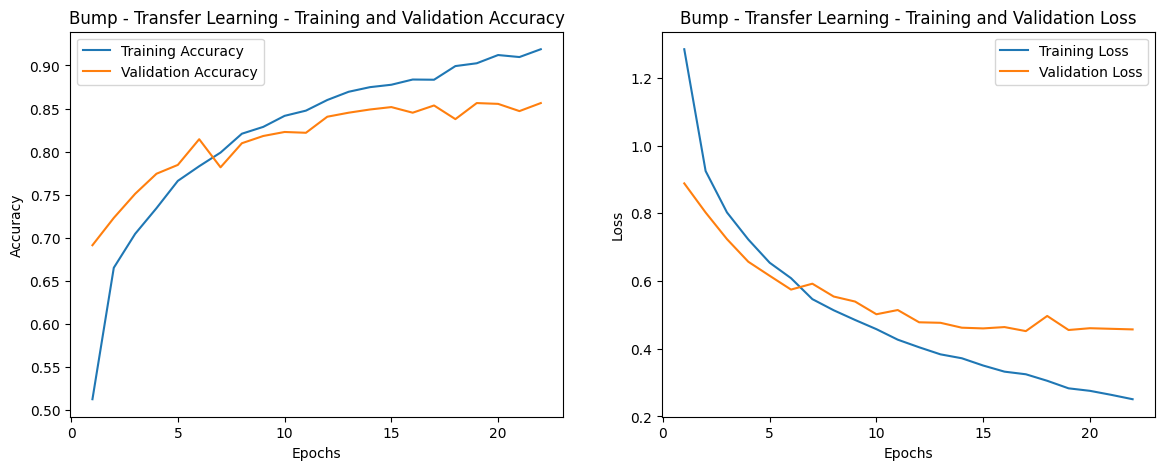

1/1 [==============================] - 0s 118ms/step

Reporte de Clasificación para Bump - Transfer Learning:

                  precision    recall  f1-score   support

 air_conditioner       0.82      0.90      0.86       143
children_playing       0.74      0.83      0.78       133
        drilling       0.87      0.91      0.89       168
  engine_idiling       0.86      0.81      0.83       149
      jackhammer       0.93      0.92      0.93       157
           siren       0.89      0.87      0.88       161
    street_music       0.85      0.72      0.78       161

        accuracy                           0.85      1072
       macro avg       0.85      0.85      0.85      1072
    weighted avg       0.86      0.85      0.85      1072



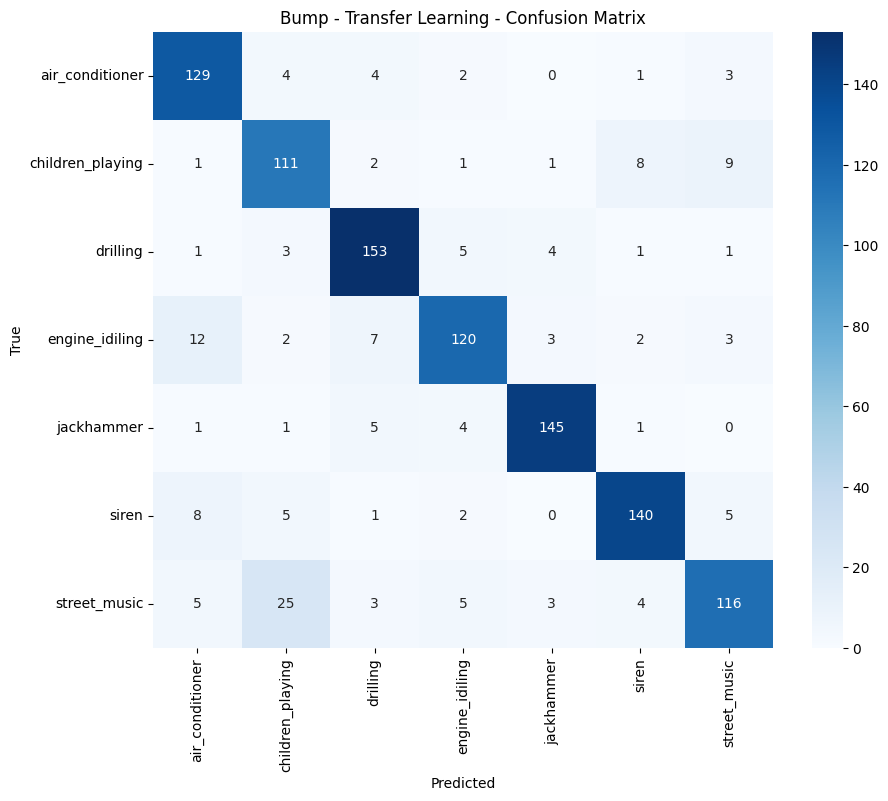

Epoch 1/50
86/86 [==============================] - 70s 494ms/step - loss: 9.5812 - accuracy: 0.2266 - val_loss: 2.2881 - val_accuracy: 0.5252
Epoch 2/50
86/86 [==============================] - 38s 436ms/step - loss: 5.5198 - accuracy: 0.3012 - val_loss: 3.5003 - val_accuracy: 0.4272
Epoch 3/50
86/86 [==============================] - 38s 435ms/step - loss: 2.7273 - accuracy: 0.4000 - val_loss: 2.5532 - val_accuracy: 0.4338
Epoch 4/50
86/86 [==============================] - 38s 436ms/step - loss: 1.8178 - accuracy: 0.4541 - val_loss: 1.7916 - val_accuracy: 0.4767
Epoch 5/50
86/86 [==============================] - 40s 453ms/step - loss: 1.4512 - accuracy: 0.4993 - val_loss: 1.4547 - val_accuracy: 0.5243
Epoch 6/50
86/86 [==============================] - 41s 468ms/step - loss: 1.3000 - accuracy: 0.5436 - val_loss: 1.2827 - val_accuracy: 0.5569
Epoch 7/50
86/86 [==============================] - 41s 467ms/step - loss: 1.2288 - accuracy: 0.5627 - val_loss: 1.1843 - val_accuracy: 0.5802

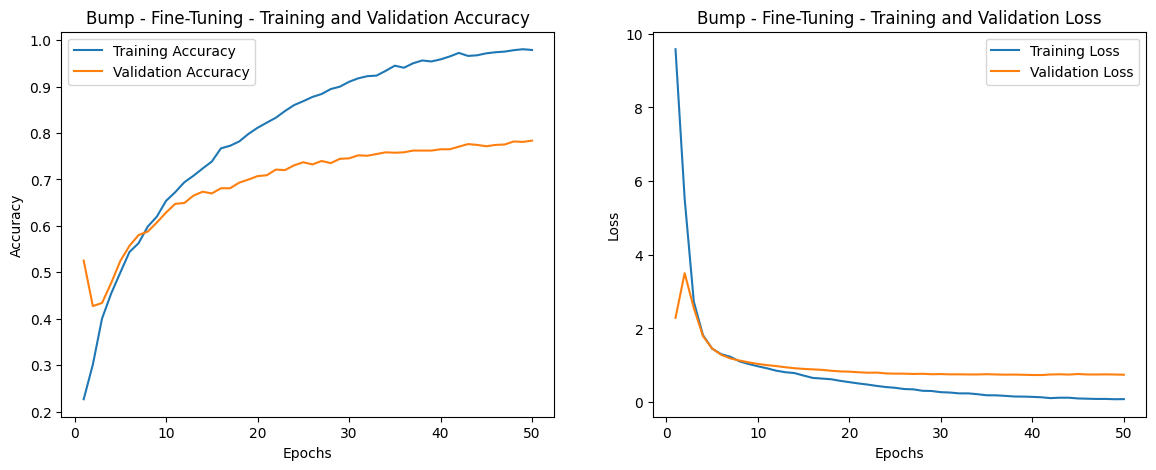

1/1 [==============================] - 0s 125ms/step

Reporte de Clasificación para Bump - Fine-Tuning:

                  precision    recall  f1-score   support

 air_conditioner       0.79      0.83      0.81       143
children_playing       0.64      0.71      0.67       133
        drilling       0.80      0.77      0.78       168
  engine_idiling       0.83      0.75      0.79       149
      jackhammer       0.85      0.89      0.87       157
           siren       0.84      0.84      0.84       161
    street_music       0.74      0.70      0.72       161

        accuracy                           0.78      1072
       macro avg       0.78      0.78      0.78      1072
    weighted avg       0.79      0.78      0.78      1072



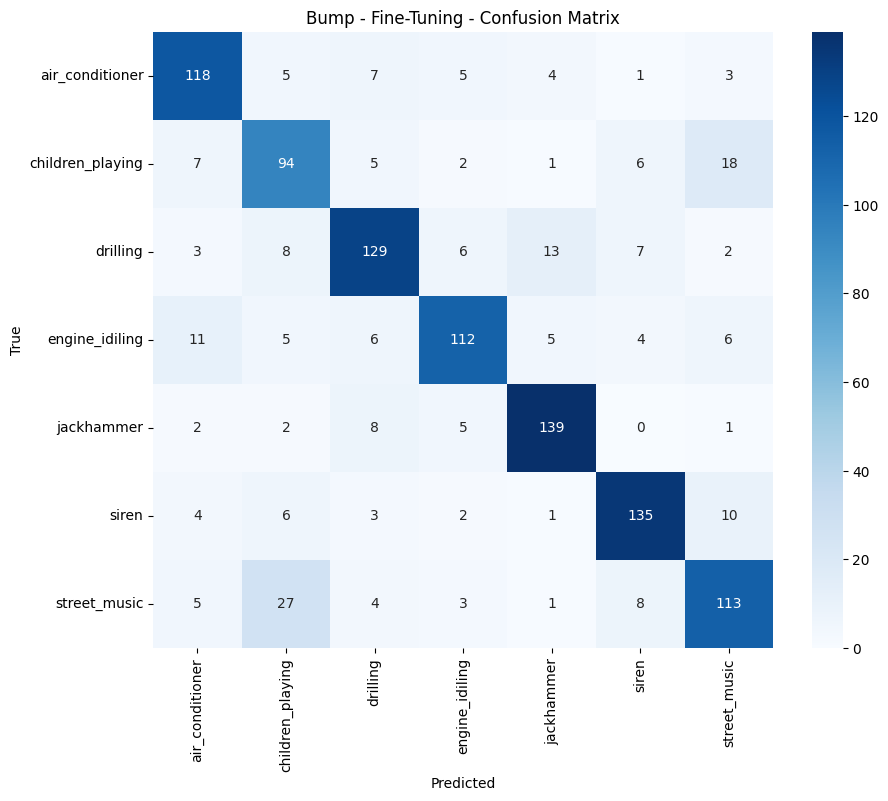

Procesando representación: Morlet
Found 5362 files belonging to 7 classes.
Using 4290 files for training.
Found 5362 files belonging to 7 classes.
Using 1072 files for validation.
Epoch 1/25
86/86 [==============================] - 46s 320ms/step - loss: 1.3809 - accuracy: 0.4650 - val_loss: 1.0020 - val_accuracy: 0.6427
Epoch 2/25
86/86 [==============================] - 22s 248ms/step - loss: 0.9982 - accuracy: 0.6242 - val_loss: 0.8743 - val_accuracy: 0.6810
Epoch 3/25
86/86 [==============================] - 22s 249ms/step - loss: 0.8534 - accuracy: 0.6883 - val_loss: 0.7549 - val_accuracy: 0.7239
Epoch 4/25
86/86 [==============================] - 22s 249ms/step - loss: 0.7751 - accuracy: 0.7284 - val_loss: 0.7188 - val_accuracy: 0.7472
Epoch 5/25
86/86 [==============================] - 22s 242ms/step - loss: 0.7202 - accuracy: 0.7406 - val_loss: 0.6690 - val_accuracy: 0.7612
Epoch 6/25
86/86 [==============================] - 22s 246ms/step - loss: 0.6594 - accuracy: 0.7634 - va

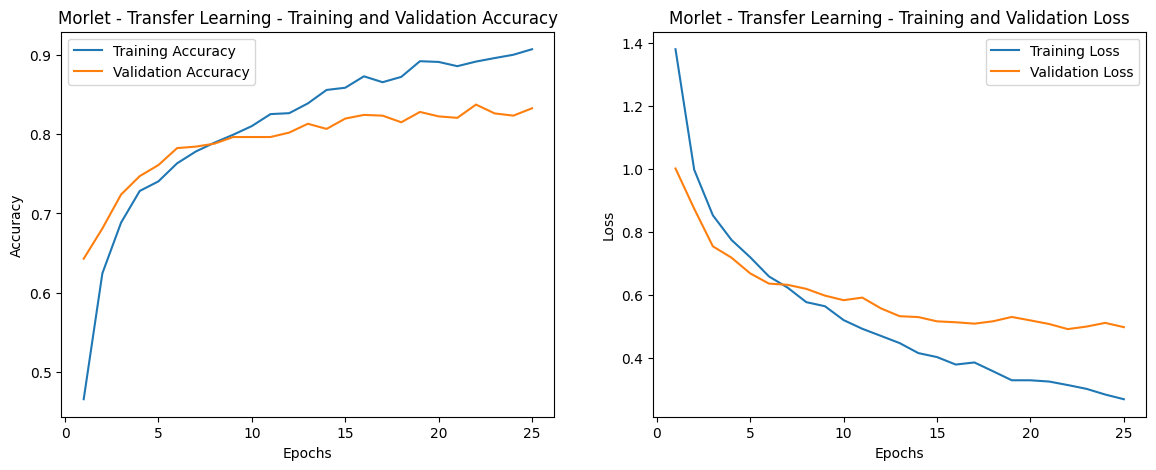

1/1 [==============================] - 0s 109ms/step

Reporte de Clasificación para Morlet - Transfer Learning:

                  precision    recall  f1-score   support

 air_conditioner       0.86      0.83      0.84       143
children_playing       0.71      0.72      0.72       133
        drilling       0.78      0.90      0.84       168
  engine_idiling       0.93      0.83      0.88       149
      jackhammer       0.87      0.91      0.89       157
           siren       0.93      0.86      0.89       161
    street_music       0.77      0.76      0.77       161

        accuracy                           0.83      1072
       macro avg       0.84      0.83      0.83      1072
    weighted avg       0.84      0.83      0.83      1072



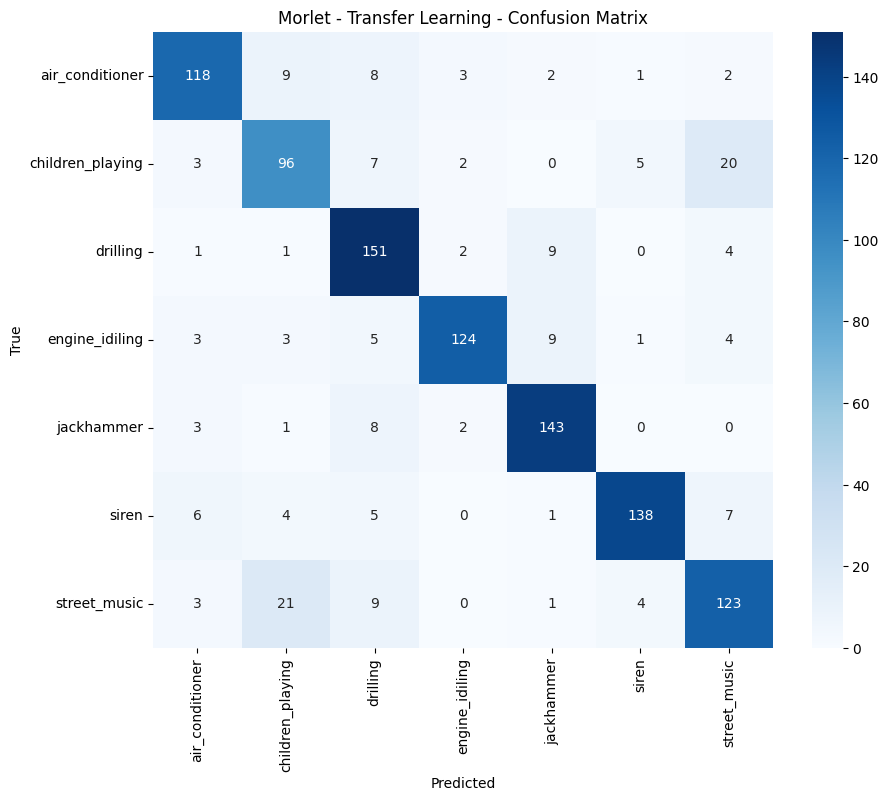

Epoch 1/50
86/86 [==============================] - 70s 492ms/step - loss: 13.0162 - accuracy: 0.2536 - val_loss: 4.3274 - val_accuracy: 0.4338
Epoch 2/50
86/86 [==============================] - 39s 447ms/step - loss: 6.6730 - accuracy: 0.3231 - val_loss: 5.4220 - val_accuracy: 0.3498
Epoch 3/50
86/86 [==============================] - 38s 434ms/step - loss: 3.1681 - accuracy: 0.3678 - val_loss: 3.4172 - val_accuracy: 0.3657
Epoch 4/50
86/86 [==============================] - 40s 449ms/step - loss: 2.1396 - accuracy: 0.4207 - val_loss: 2.3517 - val_accuracy: 0.4188
Epoch 5/50
86/86 [==============================] - 40s 456ms/step - loss: 1.7985 - accuracy: 0.4692 - val_loss: 1.9175 - val_accuracy: 0.4524
Epoch 6/50
86/86 [==============================] - 39s 450ms/step - loss: 1.6067 - accuracy: 0.4895 - val_loss: 1.6756 - val_accuracy: 0.4711
Epoch 7/50
86/86 [==============================] - 38s 438ms/step - loss: 1.4599 - accuracy: 0.5184 - val_loss: 1.5399 - val_accuracy: 0.494

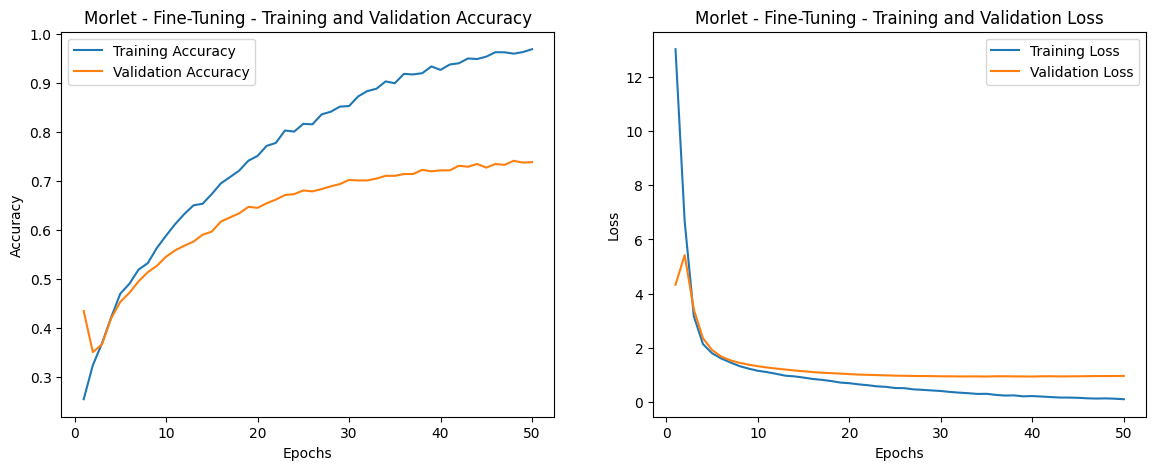

1/1 [==============================] - 0s 119ms/step

Reporte de Clasificación para Morlet - Fine-Tuning:

                  precision    recall  f1-score   support

 air_conditioner       0.71      0.72      0.72       143
children_playing       0.61      0.71      0.66       133
        drilling       0.77      0.77      0.77       168
  engine_idiling       0.80      0.74      0.77       149
      jackhammer       0.80      0.82      0.81       157
           siren       0.82      0.81      0.82       161
    street_music       0.65      0.60      0.62       161

        accuracy                           0.74      1072
       macro avg       0.74      0.74      0.74      1072
    weighted avg       0.74      0.74      0.74      1072



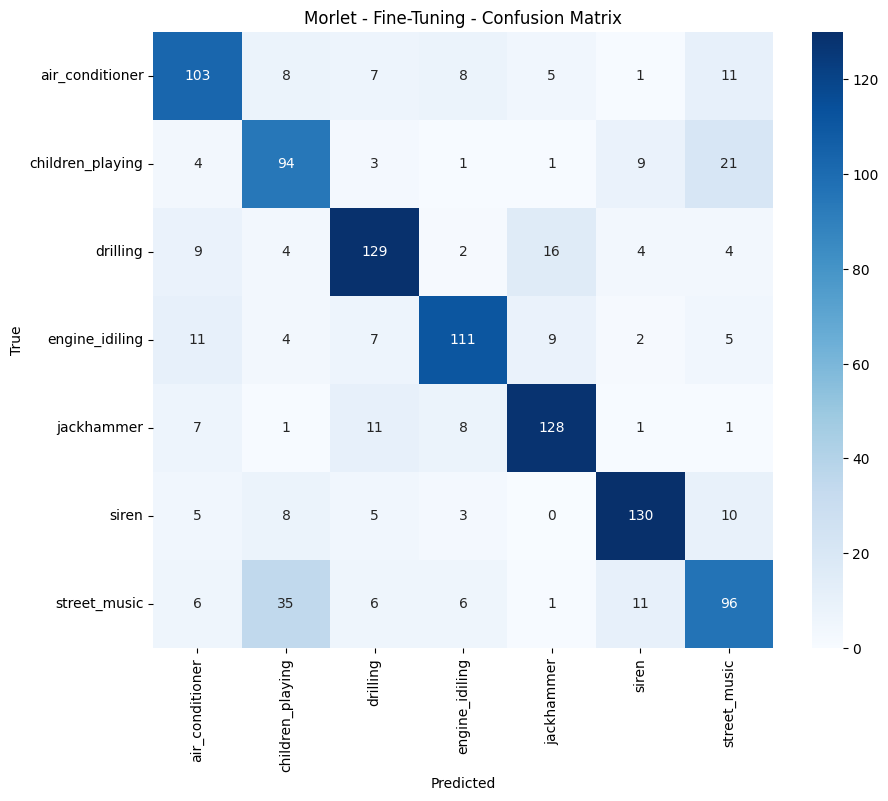

In [10]:
final_results = []  #Creacion de lista de registros - metricas

for representation, data_path in data_paths.items():
    print(f"Procesando representación: {representation}")

    # Cargar datos y obtener class_names
    train_ds, val_ds, class_names = load_and_preprocess_data(data_path)
    num_classes = len(class_names)

    # Crear y entrenar modelo
    model = create_model(num_classes)
    history = train_model(model, train_ds, val_ds)
    plot_training_history(history, title=f"{representation} - Transfer Learning")

    # Generar reporte y matriz de confusión (Transfer Learning)
    report = generate_classification_report(model, val_ds, class_names, title=f"{representation} - Transfer Learning")

    # Guardar resultados iniciales
    final_results.append({
        "Representation": representation,
        "Stage": "Transfer Learning",
        "Accuracy": report["accuracy"],
        "Macro F1": report["macro avg"]["f1-score"],
        "Weighted F1": report["weighted avg"]["f1-score"]
    })

    # Fine-tuning
    fine_tune_history = fine_tune_model(model, train_ds, val_ds)
    plot_training_history(fine_tune_history, title=f"{representation} - Fine-Tuning")

    # Generar reporte y matriz de confusión (Fine-Tuning)
    fine_tune_report = generate_classification_report(model, val_ds, class_names, title=f"{representation} - Fine-Tuning")

    # Guardar resultados Fine-Tuning
    final_results.append({
        "Representation": representation,
        "Stage": "Fine-Tuning",
        "Accuracy": fine_tune_report["accuracy"],
        "Macro F1": fine_tune_report["macro avg"]["f1-score"],
        "Weighted F1": fine_tune_report["weighted avg"]["f1-score"]
    })

    # Guardar modelo
    model.save(f"model_{representation}.keras")

In [11]:
# Crear DataFrame consolidado
df_results = pd.DataFrame(final_results)

# Mostrar el reporte completo
print("\n**Reporte Consolidado:**\n")
print(df_results)

# Calcular puntaje combinado (promedio de todas las métricas)
df_results["Average Score"] = df_results[["Accuracy", "Macro F1", "Weighted F1"]].mean(axis=1)

# Determinar el mejor modelo en base al puntaje combinado
best_model = df_results.sort_values(by="Average Score", ascending=False).iloc[0]

# Mostrar el mejor modelo
print("\n**Mejor Representación (Basado en Todas las Métricas):**")
print(best_model)


**Reporte Consolidado:**

  Representation              Stage  Accuracy  Macro F1  Weighted F1
0        Mel-512  Transfer Learning  0.880597  0.879873     0.880465
1        Mel-512        Fine-Tuning  0.725746  0.724944     0.726176
2       Mel-1024  Transfer Learning  0.889925  0.889494     0.889868
3       Mel-1024        Fine-Tuning  0.771455  0.770354     0.771528
4           Bump  Transfer Learning  0.852612  0.850385     0.852197
5           Bump        Fine-Tuning  0.783582  0.781677     0.783764
6         Morlet  Transfer Learning  0.833022  0.831450     0.833547
7         Morlet        Fine-Tuning  0.737873  0.736143     0.738163

**Mejor Representación (Basado en Todas las Métricas):**
Representation             Mel-1024
Stage             Transfer Learning
Accuracy                   0.889925
Macro F1                   0.889494
Weighted F1                0.889868
Average Score              0.889763
Name: 2, dtype: object


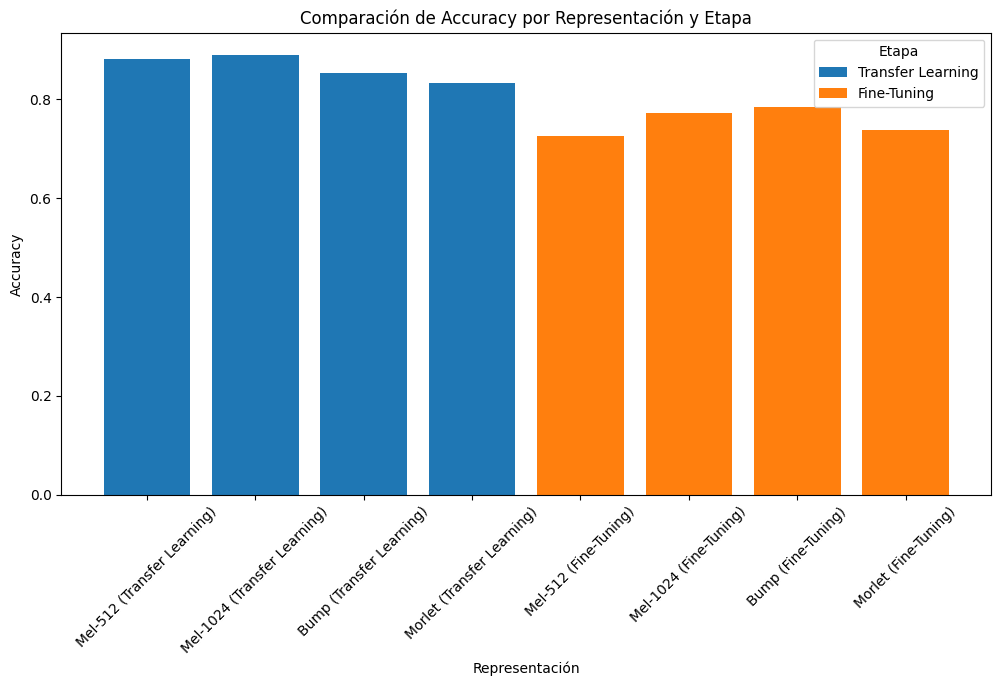

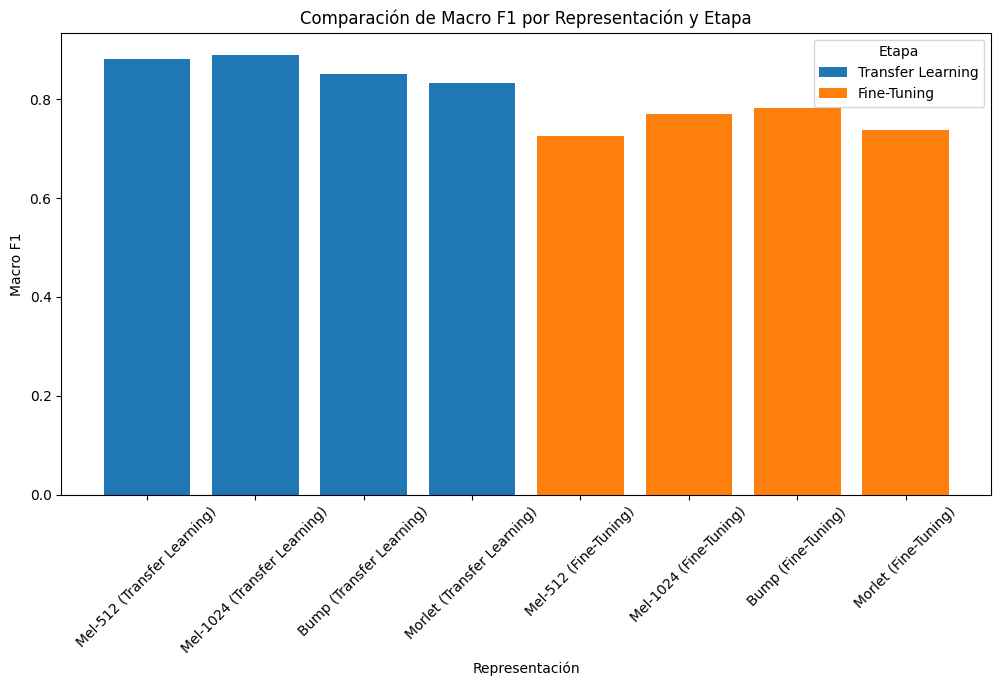

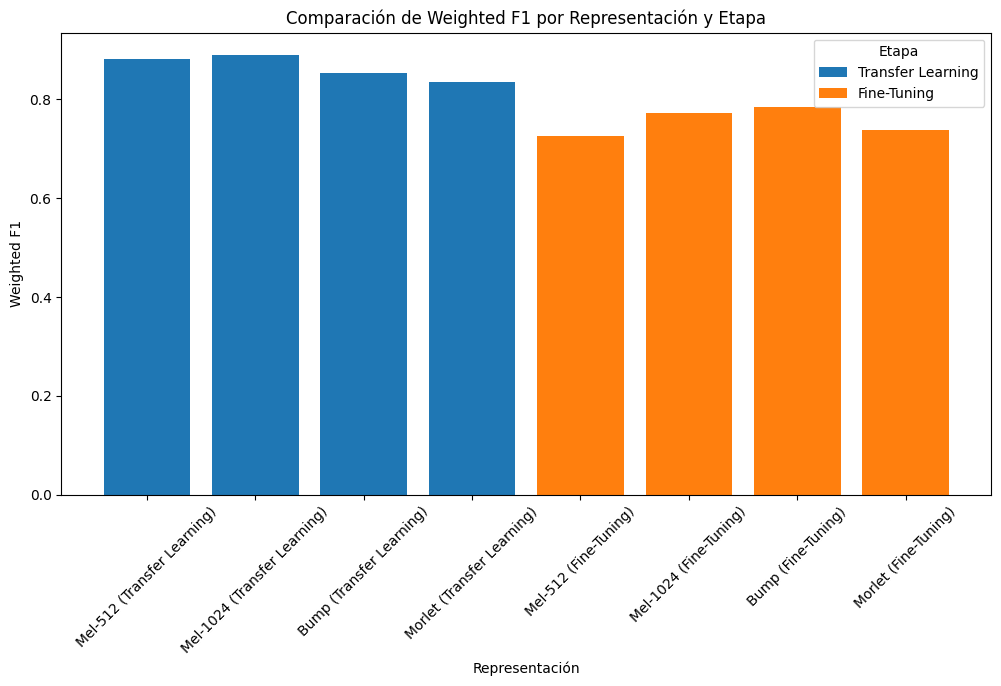

In [12]:
# Gráficos comparativos por métrica
metrics = ["Accuracy", "Macro F1", "Weighted F1"]
for metric in metrics:
    plt.figure(figsize=(12, 6))
    for stage in df_results["Stage"].unique():
        stage_data = df_results[df_results["Stage"] == stage]
        plt.bar(stage_data["Representation"] + f" ({stage})", stage_data[metric], label=stage)

    plt.title(f"Comparación de {metric} por Representación y Etapa")
    plt.xlabel("Representación")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend(title="Etapa")
    plt.show()

In [13]:
# Ordenar resultados por puntaje promedio
df_results_sorted = df_results.sort_values(by="Average Score", ascending=False)

# Mostrar la tabla final ordenada
print("\n**Tabla de Resultados Ordenada por Puntaje Promedio:**\n")
print(df_results_sorted)


**Tabla de Resultados Ordenada por Puntaje Promedio:**

  Representation              Stage  Accuracy  Macro F1  Weighted F1  \
2       Mel-1024  Transfer Learning  0.889925  0.889494     0.889868   
0        Mel-512  Transfer Learning  0.880597  0.879873     0.880465   
4           Bump  Transfer Learning  0.852612  0.850385     0.852197   
6         Morlet  Transfer Learning  0.833022  0.831450     0.833547   
5           Bump        Fine-Tuning  0.783582  0.781677     0.783764   
3       Mel-1024        Fine-Tuning  0.771455  0.770354     0.771528   
7         Morlet        Fine-Tuning  0.737873  0.736143     0.738163   
1        Mel-512        Fine-Tuning  0.725746  0.724944     0.726176   

   Average Score  
2       0.889763  
0       0.880312  
4       0.851731  
6       0.832673  
5       0.783008  
3       0.771112  
7       0.737393  
1       0.725622  
